In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def clean_data(train_data, test_data):
    # First, remove unnecessary columns
    train_data = train_data.drop(columns = ['education.num', 'fnlwgt'])
    test_data = test_data.drop(columns = ['education.num', 'fnlwgt'])
    
    # Now, let's focus on replacing race data
    replace_race_values = {'Black': 'Other', 'Asian-Pac-Islander': 'Other', 'Amer-Indian-Eskimo': 'Other'}
    train_data['race'] = train_data['race'].replace(replace_race_values)
    test_data['race'] = test_data['race'].replace(replace_race_values)
    
    # And now, replace grades data
    replace_education_values = {'11th': 'School', '9th': 'School', '7th-8th': 'School', '5th-6th': 'School', '10th': 'School', '1st-4th': 'School', 'Preschool': 'School', '12th': 'School'}
    train_data['education'] = train_data['education'].replace(replace_education_values)
    test_data['education'] = test_data['education'].replace(replace_education_values)
    
    # Let's now convert income values to binary
    replace_income_values = {'<=50K': 0, '>50K': 1}
    train_data['income'] = train_data['income'].replace(replace_income_values)
    test_data['income'] = test_data['income'].replace(replace_income_values)
    
    # Let's now replace ?s with nulls. Since none of the ? values are in numeric columns, there is no way to statistically approximate their values
    train_data = train_data.replace('?', np.nan)
    test_data = test_data.replace('?', np.nan)
    
    # Let's intelligently replace outliers in capital.gain with the median capital gain for individuals with similar education
    def replace_capital_gain(row, median_values):
        if row['capital.gain'] == 99999:
            return median_values[row['education']]
        else:
            return row['capital.gain']
        
    # Calculate the capital gain by education level
    median_capital_gain = train_data[train_data['capital.gain'] != 99999].groupby('education')['capital.gain'].median()
    median_capital_gain2 = test_data[test_data['capital.gain'] != 99999].groupby('education')['capital.gain'].median()
    
    # Apply replacement
    train_data['capital.gain'] = train_data.apply(lambda row: replace_capital_gain(row, median_capital_gain), axis=1)
    test_data['capital.gain'] = test_data.apply(lambda row: replace_capital_gain(row, median_capital_gain2), axis=1)
    
    # Now, we save our cleaned files
    test_data.to_csv('cleaned_test_data.csv', index=False)
    train_data.to_csv('cleaned_train_data.csv', index=False)

In [19]:
def plot_numeric_feature_correlation(cleaned_train_data):
    # First, pare down data to only include numerical values
    numeric_values = cleaned_train_data.select_dtypes(include=[int,float])
    
    # Then, find the corr of the numeric data
    corr = numeric_values.corr()
    
    # Second, init the figure from plt
    fig_corr = plt.subplots(figsize = (11, 9))
    
    # And create a heatmap
    cmap = sns.color_palette("Set2", as_cmap=True)
    
    # Draw it!
    sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5}, annot=True)
    
    # Add title and show
    plt.title('Correlation between different features')
    plt.show()



In [20]:
def plot_histogram(cleaned_train_data, income_column='income'):
    # Cleaning for hours per week
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
    cleaned_train_data['hours.per.week.category'] = pd.cut(cleaned_train_data['hours.per.week'], bins=bins, labels=labels,right=False)
    
    # Let's list all the columns the plot against income
    columns_to_plot = ['age', 'workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week.category', 'native.country']
    
    # Need to calculate how big this should be given the number of columns
    n_rows = len(columns_to_plot) // 2 + len(columns_to_plot) % 2
    
    # Create figure for all plots
    fig = plt.figure(figsize=(15, 5*n_rows))
    
    # Iterate and plot each column
    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(n_rows, 2, i)
        # Intelligently choose plot type based on data type
        if cleaned_train_data[column].dtype in [int, float]:
            # If numerical, use histplot
            sns.histplot(data=cleaned_train_data,x=column,hue=income_column, multiple='dodge', palette='tab10')
        else:
            # Use countplot
            sns.countplot(x=column,data=cleaned_train_data,hue=income_column, palette='tab10')
            
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Count of {column} by Income')
        fig.set_tight_layout(True)
        
    plt.show()
    fig.savefig('histogram.pdf')

In [21]:
# Load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
cleaned_test_data = pd.read_csv('cleaned_test_data.csv')
cleaned_train_data = pd.read_csv('cleaned_train_data.csv')

In [22]:
clean_data(train_data, test_data)

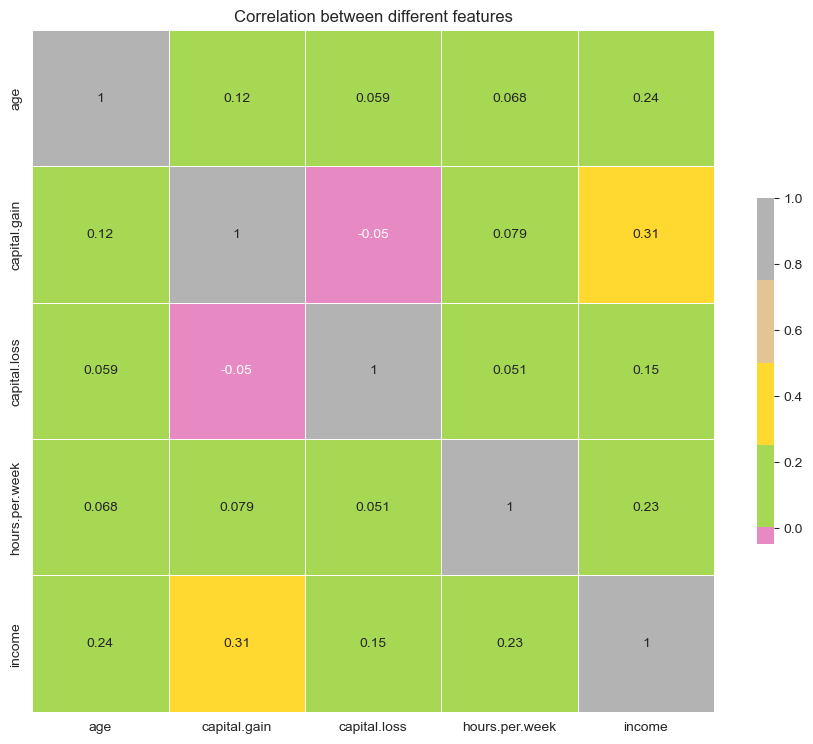

In [23]:
plot_numeric_feature_correlation(cleaned_train_data)

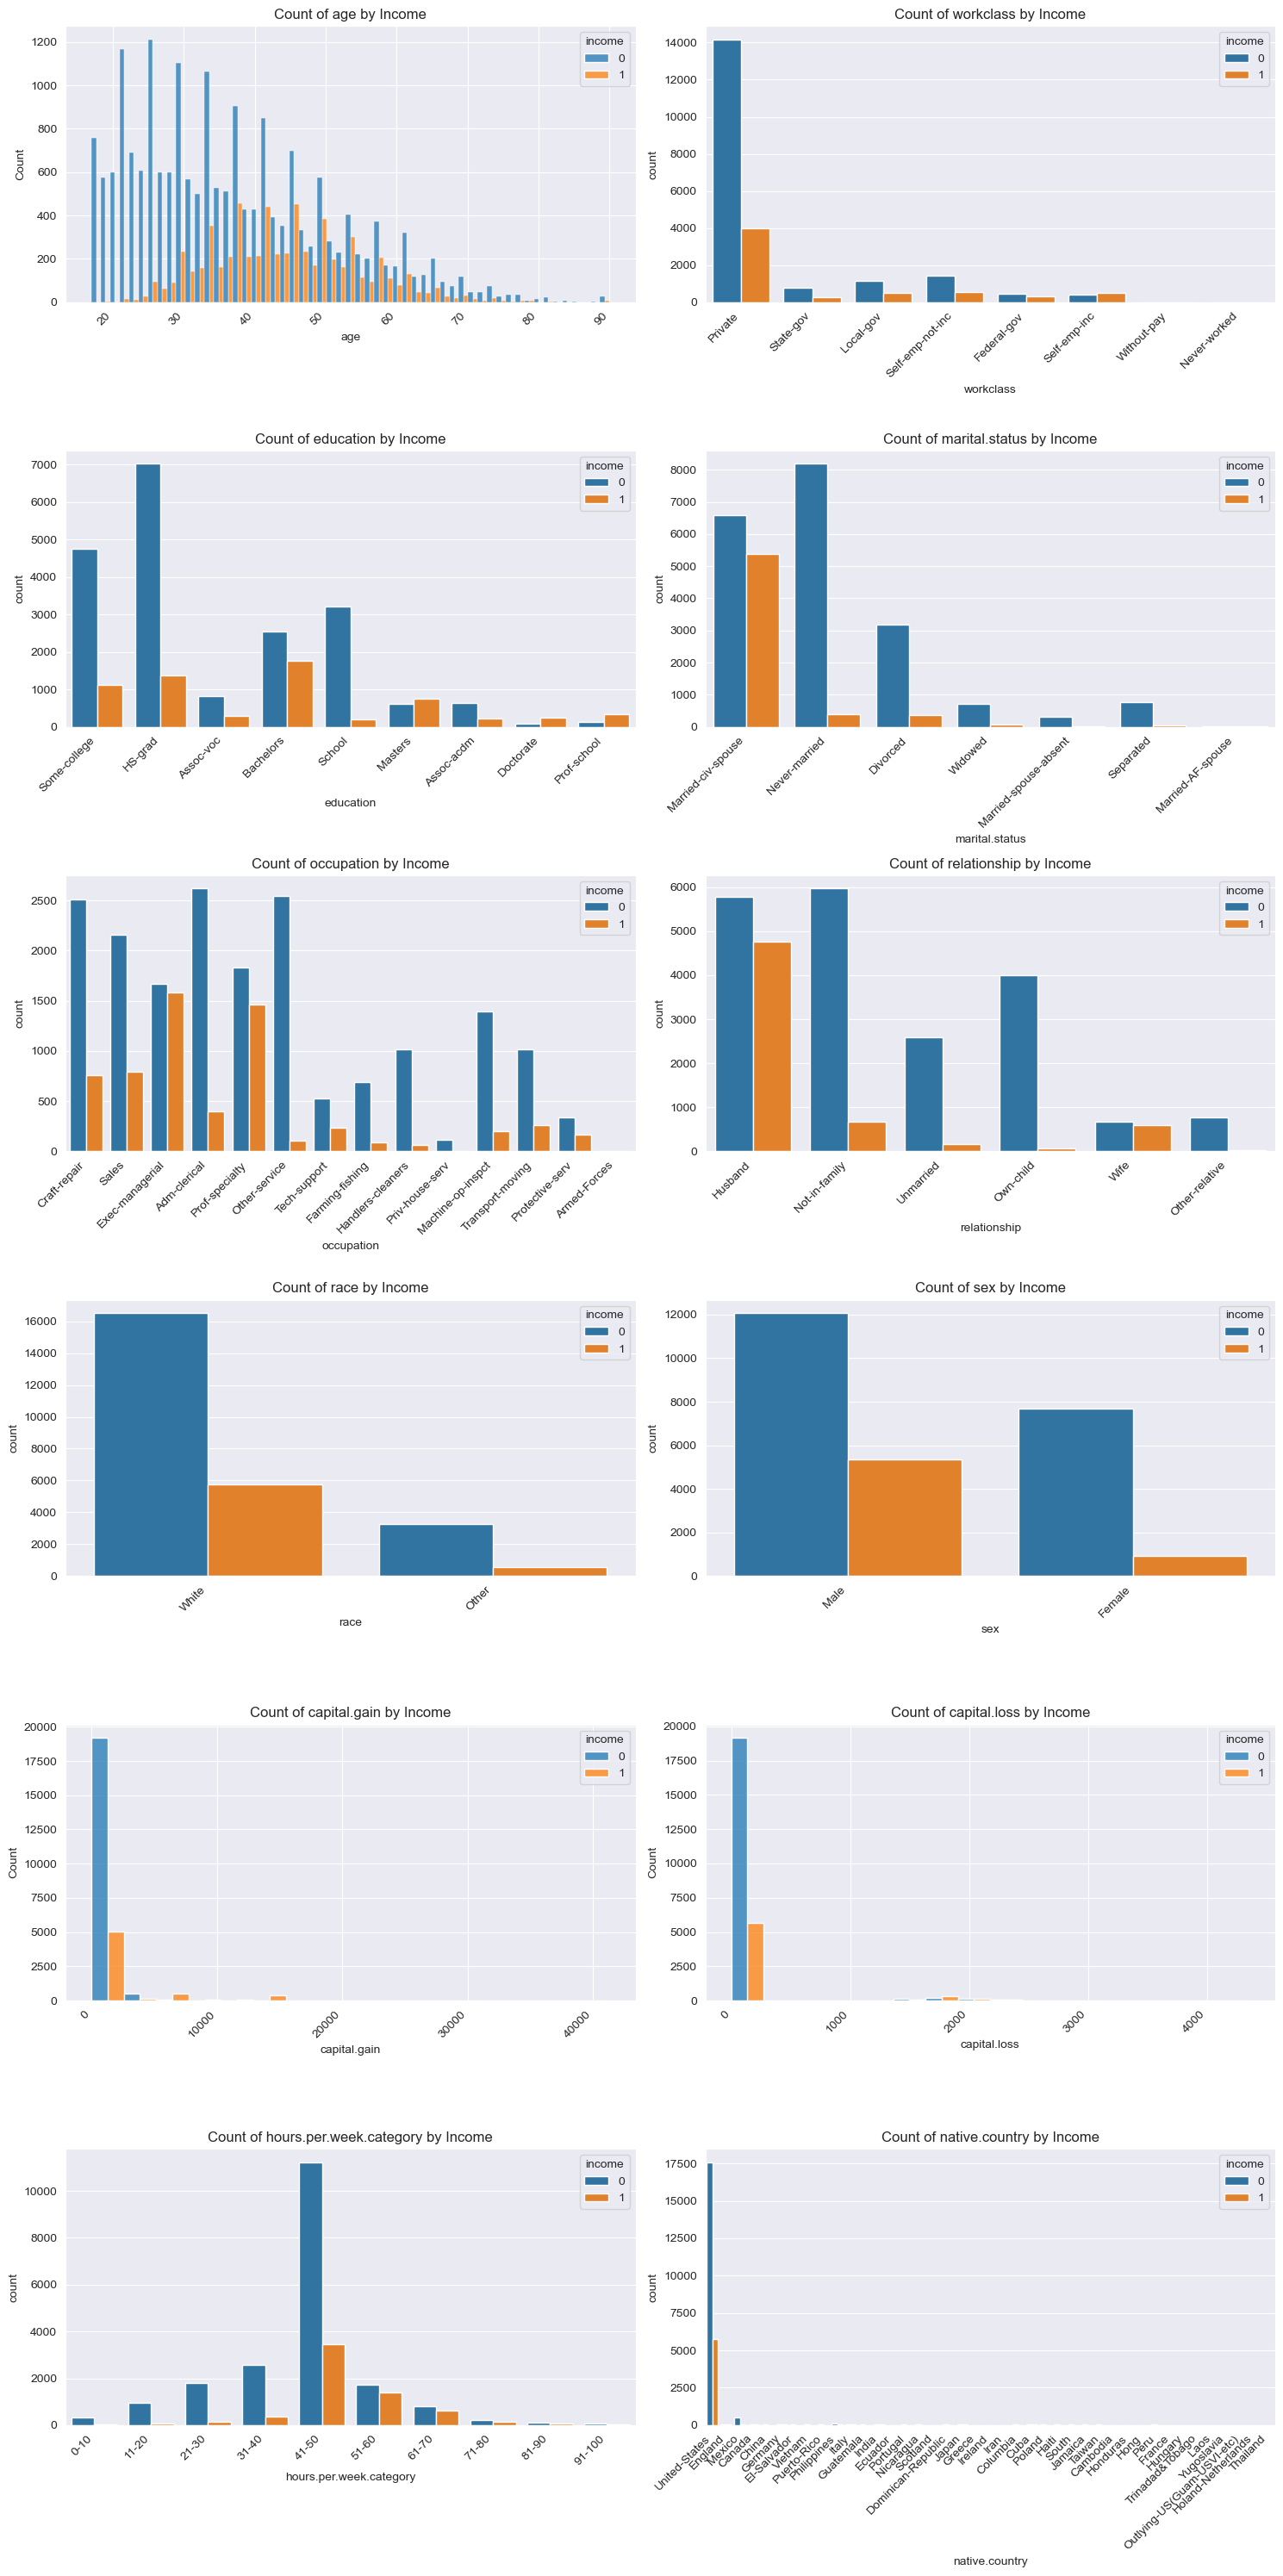

In [24]:
plot_histogram(cleaned_train_data)